In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance

In [2]:
# this reads in the new neighbor catalog, originally made for CIGALE
df = pd.read_csv('post_correction_data.csv')

In [3]:
print('Before all the eliminations, there are a total of', df.shape[0], 'sources.')

Before all the eliminations, there are a total of 994 sources.


# <b>CRITERION 1</b>: Minimum of 3 detections, or less if there's A3COSMOS/ALMA data

In [5]:
# in a previous .csv file, all the neighbors are id'd based on their central galaxy.
# since this id is such a minor part of our work and isn't present in our later .csv or .txt files,
# we just retrieve these "our_id" values from the old .csv file, and then use them for our new work.
df2 = pd.read_csv('neighbor_data.csv')
df2 = df2[df2['id'].duplicated(keep='first')==False]
catalog_id = df2['id']
our_id = df2['our_id']
our_ra = df2['ra']
our_dec = df2['dec']
our_z = df2['z_spec']

In [6]:
# this opens the HDU list of the .fits catalog from A3COSMOS
hdu_list = fits.open('/Volumes/LaCie/COSMOS_DATA/a3cosmos_blind.fits')
hdu_list.info()

# this gets the data of the catalog
a3cosmos = hdu_list[1].data

Filename: /Volumes/LaCie/COSMOS_DATA/a3cosmos_blind.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   ()      
  1  J_ApJS_244_40_blind    1 BinTableHDU    115   1134R x 16C   [D, D, D, D, E, E, E, E, E, E, E, D, E, E, E, B]   


In [7]:
### matching coords from the A3COSMOS catalog using SkyCoord 
# create SkyCoord arrays (?) with the RA and Dec of the galaxies in both catalogs
radio_cat = SkyCoord(ra=a3cosmos['RAJ2000']*u.degree, dec=a3cosmos['DEJ2000']*u.degree)
spec_cat = SkyCoord(ra=our_ra.values*u.degree, dec=our_dec.values*u.degree)

# use search_around_sky to find matching indices (matching in RA and Dec) in each catalog
idx_radio, idx_spec, d2d, d3d = spec_cat.search_around_sky(radio_cat, 1*u.arcsec)

# use the matching indices to the new catalog to see where we have ground-based data of our neighbors
print(np.size(idx_radio), 'is the number of matches between the A3COSMOS and the spectroscopic catalogs.')

2 is the number of matches between the A3COSMOS and the spectroscopic catalogs.


In [8]:
# this calls the names of all the columns with flux measurements for all the galaxies
f_cols = [col for col in df.columns if '_err' not in col and col != 'id' and col != 'redshift']

In [9]:
# this saves all the neighbor ids that pass criterion 1
crit1_neigh_id = []

# this loops over all the galaxies from the .csv file, then reads their corresponding fluxes
# in all our bands to see if each of them has at least 3 different detections. if said galaxy does, 
# then we save the id of that galaxy, meaning that it passes criterion 1.

# this loops over each of the 9 QGs in our sample group
for id in catalog_id.values:
    
    # this retrieves all the corresponding fluxes of the galaxy with the id called
    all_bands = df[df['id'] == id][f_cols].values

    # this counts how many of these fluxes are non-zeros (i.e. how many detections there are)
    available_fluxes = np.count_nonzero(all_bands)

    # this adds the galaxy's id into crit1_neigh_id if the galaxy has more than 3 detections
    if available_fluxes >= 3:
        crit1_neigh_id.append(id)
        
print(len(crit1_neigh_id), 'is the total amount of neighbors that pass criterion 1.')

849 is the total amount of neighbors that pass criterion 1.


# <b>CRITERION 2:</b> |z$_{QG}$ - z$_{gal}$| < 0.5

In [11]:
# this reads in the results FITS file that CIGALE made
cigale_results = fits.open('out/results.fits')
cigale_results.info()

Filename: out/results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    374   994R x 123C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [12]:
# this gets the data from the results FITS file
cigale_data = Table(cigale_results[1].data).to_pandas()

In [13]:
# this selects only the rows in cigale_data and our_id
# whose corresponding source already passed criterion 1
reduced_cigale = cigale_data.loc[cigale_data['id'].isin(crit1_neigh_id)]
reduced_our_id = our_id[catalog_id.isin(crit1_neigh_id)]

In [14]:
cigale_id = reduced_cigale['id'].values
cigale_z = reduced_cigale['bayes.universe.redshift'].values
cigale_z_err = reduced_cigale['bayes.universe.redshift_err'].values

In [15]:
# now read in the RAs and Decs of our 9 galaxies
info = np.genfromtxt('basic_data.txt', delimiter=' ', dtype=['U15', '<f8','<f8', '<f8'])

# this gets the galaxy redshifts for all the 9 galaxies
galaxy_redshift = np.zeros(np.size(info), dtype=float)
for i in range(np.size(info)):
    galaxy_redshift[i] = info[i][3]

In [16]:
# this saves all the neighbor ids that pass criterion 2
crit2_neigh_id = []

# this loops over each of the 9 QGs in our sample group
for our_galaxy in range(np.size(galaxy_redshift)):
    # this selects the neighbor IDs, ONLY the ones that passed criterion 1
    neigh_id = np.array(cigale_id[reduced_our_id==our_galaxy])

    # this reads in the estimated z and errors of all the neighbors around each galaxy that passed criterion 1
    neigh_z = np.array(cigale_z[reduced_our_id==our_galaxy])
    neigh_z_err = np.array(cigale_z_err[reduced_our_id==our_galaxy])

    # this sets criterion 2
    criteria = (np.abs(neigh_z + neigh_z_err - galaxy_redshift[our_galaxy]) <= 0.5) | (np.abs(neigh_z - neigh_z_err - galaxy_redshift[our_galaxy]) <= 0.5)

    # this finds neighbor IDs that pass criterion 2
    ok_neigh_id = neigh_id[criteria]

    # this saves the indices of the neighbors that pass criterion 2
    crit2_neigh_id.extend(ok_neigh_id)

print(len(crit2_neigh_id), 'is the total amount of neighbors that pass criterion 2.')

233 is the total amount of neighbors that pass criterion 2.


Now, we save the plots of the fits that passed both criteria altogether into a separate .pdf file.

In [18]:
import PyPDF2, os

In [19]:
pdfiles = []
for filename in os.listdir('out/'):
    if filename[0:6] in str(crit2_neigh_id) and filename.endswith('.pdf'):
        if filename != 'merged.pdf':
            pdfiles.append(filename)
                        
pdfiles.sort(key = str.lower)

In [20]:
pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('out/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('merged.pdf')

# Miscellaneous Eliminations

First, compare our new sample to our old sample, where there are 160 potential neighbors (see the notebook named <b>eliminate_neighbors_old_data.ipynb</b>). We're doing this just to see how much our two samples differ from one another.

In [22]:
# this reads in the .txt file where we've saved the indices of the potential neighbors
old_potential = np.genfromtxt('old_data_potential_neighbors.txt', dtype=('float','f8'))

In [199]:
# this converts crit2_neigh_id into an array of floats so it's easier to compare
new_potential = np.array(crit2_neigh_id, dtype=('float','f8'))

In [201]:
# this is to find how many common elements are in both arrays
common = np.intersect1d(old_potential, new_potential)

In [203]:
# this reads in the old results file
cigale_old = fits.open('out_all 2.35.35 PM/results.fits')
cigale_old.info()

# this gets the data from the old results file
cigale_old_table = Table(cigale_old[1].data).to_pandas()

# this locates the common potential neighbors in the old results file
info_cigale_old = cigale_old_table.loc[cigale_old_table['id'].isin(common)]

Filename: out_all 2.35.35 PM/results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    386   994R x 127C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [205]:
# this locates the common potential neighbors in the new results file
info_cigale_new = cigale_data.loc[cigale_data['id'].isin(common)]

<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_1007/92395639.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax[2].set_title('log$_{10}$(M$_*$/M$_\odot$)')


Text(0, 0.5, 'new')

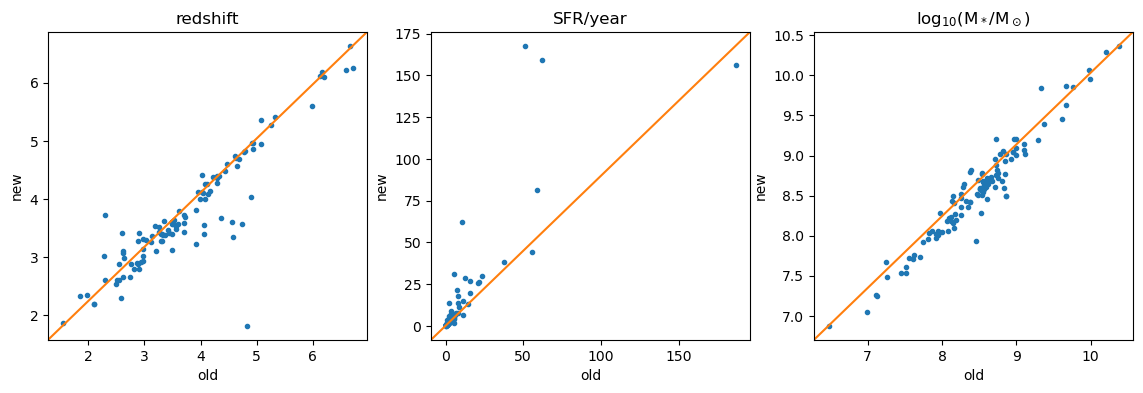

In [207]:
# now we make some diagnostic plots to compare the old and new results
# (only looking at the common potential neighbors in both samples)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(info_cigale_old['bayes.universe.redshift'].values, info_cigale_new['bayes.universe.redshift'].values, '.')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].set_title('redshift')
ax[0].set_xlabel('old')
ax[0].set_ylabel('new')

ax[1].plot(info_cigale_old['bayes.sfh.sfr'].values, info_cigale_new['bayes.sfh.sfr'].values, '.')
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].set_title('SFR/year')
ax[1].set_xlabel('old')
ax[1].set_ylabel('new')

ax[2].plot(np.log10(info_cigale_old['bayes.stellar.m_star'].values), np.log10(info_cigale_new['bayes.stellar.m_star'].values), '.')
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].set_title('log$_{10}$(M$_*$/M$_\odot$)')
ax[2].set_xlabel('old')
ax[2].set_ylabel('new')

From these plots, we see that the new fits and the old fits are essentially the same, meaning there's no need to reanalyze the potential neighbors selected from the old sample. Since we already saved the IDs of the good fits selected from the old sample, we'll just use that list.

In [225]:
# this reads in the .txt file where we've saved the indices of the potential 
# neighbors with good fits, as selected from the old sample
old_good_fits_idx = np.genfromtxt('old_good_fits.txt', dtype=('float','f8'))

# now, we pick out the ones that are good fits and are also common between the old and new samples
good_fits_1 = np.intersect1d(common, old_good_fits_idx)

In [229]:
# this takes the data of all the new fits based on the indices from the old good fits
good_fits_from_old = cigale_data.loc[cigale_data['id'].isin(good_fits_1)]

In [235]:
good_fits_from_old

,id,bayes.attenuation.E_BVs,bayes.attenuation.E_BVs_err,bayes.sfh.age_main,bayes.sfh.age_main_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,...,best.subaru.suprime.IB427,best.subaru.suprime.IB505,best.subaru.suprime.IB574,best.subaru.suprime.IB709,best.subaru.suprime.IB827,best.subaru.suprime.NB711,best.subaru.suprime.NB816,best.spitzer.irac.ch1,best.spitzer.irac.ch2,best.spitzer.irac.ch3
0,756228,0.088857,0.035769,417.624948,354.005857,3.278320,0.525038,3.558649,1.834240,2.915679,...,1.467487e-05,0.000030,0.000063,0.000065,0.000071,0.000065,0.000071,0.000120,0.000143,0.000148
2,756324,0.142144,0.081505,526.144334,365.795022,3.136364,0.510097,3.385109,2.849470,2.944019,...,1.228186e-05,0.000049,0.000037,0.000043,0.000043,0.000043,0.000043,0.000102,0.000107,0.000101
5,756381,0.089931,0.002999,100.658272,22.407275,3.601789,0.055604,7.290918,0.364546,3.845178,...,1.186805e-05,0.000057,0.000117,0.000121,0.000124,0.000120,0.000124,0.000123,0.000154,0.000106
19,756650,0.450849,0.021279,100.002315,1.087818,3.599899,0.021833,19.724432,1.713810,10.549690,...,3.704218e-07,0.000003,0.000009,0.000013,0.000015,0.000013,0.000015,0.000131,0.000226,0.000186
25,756791,0.010646,0.018706,531.476156,344.005582,3.382148,0.087402,4.264740,1.258573,4.071001,...,1.147067e-04,0.000167,0.000256,0.000243,0.000223,0.000241,0.000225,0.000146,0.000159,0.000107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,823918,0.015325,0.033122,628.563505,441.254153,4.119372,1.175349,1.178090,0.800805,1.343887,...,5.730105e-06,0.000023,0.000037,0.000038,0.000036,0.000037,0.000036,0.000037,0.000047,0.000036
978,823998,0.006525,0.019346,484.234110,417.265533,4.258428,0.979942,1.457550,0.721397,1.414571,...,0.000000e+00,0.000000,0.000003,0.000013,0.000060,0.000012,0.000060,0.000024,0.000039,0.000027
981,824034,0.006721,0.016807,497.113674,337.545777,2.540534,0.277544,0.228684,0.087718,0.219566,...,1.675115e-05,0.000018,0.000017,0.000017,0.000016,0.000017,0.000017,0.000018,0.000017,0.000017
983,824065,0.014784,0.028866,334.670839,336.738491,3.015252,0.670935,0.487810,0.221449,0.374835,...,5.108543e-06,0.000018,0.000030,0.000026,0.000024,0.000026,0.000024,0.000016,0.000021,0.000014


Next, we visually inspect the neighbors that did not appear in our old sample.

In [294]:
# we pick out the IDs of the new potential neighbors
other_new_fits = np.setdiff1d(new_potential, common)

In [296]:
# now, we make a PDF file of all the plots of the new fits. this is so that it's easier to visually inspect them all
import PyPDF2, os

pdfiles = []
for filename in os.listdir('out/'):
    if filename[0:6] in str(other_new_fits) and filename.endswith('.pdf'):
        pdfiles.append(filename)
                        
pdfiles.sort(key = str.lower)

pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('out/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('all_new_fits.pdf')

After making a list of visually inspected bad fits, we pick out the good fits and save them.

In [316]:
# this reads in the .txt file where we've saved the indices of the bad fits
new_bad_fits_idx = np.genfromtxt('new_bad_fits.txt', dtype=('float','f8'))

# now, we pick out the ones that are good fits and are also common between the old and new samples
good_fits_2 = np.setdiff1d(other_new_fits, new_bad_fits_idx)

In [318]:
# now, we make a PDF file of all the plots of the new fits. this is so that it's easier to visually inspect them all
import PyPDF2, os

pdfiles = []
for filename in os.listdir('out/'):
    if filename[0:6] in str(good_fits_2) and filename.endswith('.pdf'):
        pdfiles.append(filename)
                        
pdfiles.sort(key = str.lower)

pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('out/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('good_fits.pdf')

Let's wait for Arianna...

In [268]:
#wow = cigale_data.loc[cigale_data['id'].isin(other_new_fits)]

wow = cigale_data.loc[cigale_data['id'] == 823841]
m_star_wow = wow['bayes.stellar.m_star'].values
sfr_wow = wow['bayes.sfh.sfr'].values
ssfr_wow = np.log10(sfr_wow/m_star_wow)
print(ssfr_wow)

[-7.71853116]


# <b>Penultimate Elimination</b>

After visually inspecting all the 160 fits, we separate them into good fits, fits that need to be rerun without nebular emissions, fits that need to be checked by looking at the postage stamp (and later rerunning without nebular emissions), and completely bad fits. Below are the IDs that belong to each category.

In [26]:
nebular_rerun = np.array([659622, 756994, 661909, 642604, 614224, 614320, 614548, 614670, 
                 659534, 661661, 661662, 661988, 661989, 662092, 756380, 756650, 
                 757025, 759202, 781608, 781845, 784642, 784663, 823371, 759485, 
                 759140, 759207, 829990, 780261, 757435, 757212, 659693, 614256, 
                 641835, 641328, 614660, 614700], dtype='object')

In [27]:
postage_check = np.array([614453, 660158, 661580, 661675, 661906, 780995, 759290, 824112,
                         781056, 642340, 642380, 614114], dtype='object')

In [28]:
garbage = np.array([614134, 614257, 641889, 642233, 642502, 642581, 642605,
                    659467, 661883, 661884, 683294, 683364, 684046, 684102, 756594, 
                    757210, 782194, 782746, 783117, 783144, 783257, 784766, 823655, 823981, 830151, 680965], dtype='object')

In [29]:
good_fits_nebular = np.setdiff1d(crit2_neigh_id, np.concatenate((nebular_rerun, postage_check, garbage)))

# <b>Final Elimination</b>

After rerunning both the nebular and postage categories, we select the fits that should be selected without nebular emissions. We also decide which fits with nebular emissions should be kept. Their IDs are entered manually downhere, then combined with the good_fits array.

In [31]:
keep_no_nebular = np.array([614224, 614660, 614670, 614700, 659622, 661909, 662092, 756650, 756994, 
                            757025, 757212, 757435, 659693, 661989, 759140, 759202, 
                            784663, 824112, 780995], dtype='object')

In [32]:
keep_nebular = np.array([756380, 781608, 780261, 823371, 829990, 614114, 781056], dtype='object')

In [33]:
good_fits_nebular = np.concatenate((good_fits_nebular, keep_nebular))
good_fits_no_nebular = keep_no_nebular

In [34]:
# this reads in the FIRST results.fits file that CIGALE made without nebular emissions
cigale_noneb1 = fits.open('out_no_nebular/results.fits')
cigale_noneb1.info()

# this gets the data from the FIRST results.fits file
cigale_data_noneb1 = Table(cigale_noneb1[1].data).to_pandas()

# this takes the CIGALE-generated info
info_good_fits_noneb1 = cigale_data_noneb1.loc[cigale_data_noneb1['id'].isin(good_fits_no_nebular)]

Filename: out_no_nebular/results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    368   36R x 121C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [35]:
# this reads in the SECOND results.fits file that CIGALE made without nebular emissions
cigale_noneb2 = fits.open('out_postage_recheck/results.fits')
cigale_noneb2.info()

# this gets the data from the SECOND results.fits file
cigale_data_noneb2 = Table(cigale_noneb2[1].data).to_pandas()

# this takes the CIGALE-generated info
info_good_fits_noneb2 = cigale_data_noneb2.loc[cigale_data_noneb2['id'].isin(good_fits_no_nebular)]

Filename: out_postage_recheck/results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    368   12R x 121C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [36]:
# now, make one mega DataFrame with all the good no-nebular fits
info_good_fits_noneb = pd.concat([info_good_fits_noneb1, info_good_fits_noneb2])

In [37]:
# finally, make one mega DataFrame with all the good with-nebular fits
info_good_fits_nebular = cigale_data.loc[cigale_data['id'].isin(good_fits_nebular)]

# <b>Final DataFrame</b>

Now, we make one FINAL DataFrame with all our potential neighbors. We also retrieve their RA and Dec from the original <b>neighbor_data.csv</b> file.


In [39]:
info_good_fits = pd.concat([info_good_fits_noneb, info_good_fits_nebular])

In [40]:
# these lines retrieve their RA and Dec from the original neighbor_data.csv file
good_fits_ra = df2[['id', 'ra']].loc[catalog_id.isin(info_good_fits['id'].values)]
good_fits_dec = df2[['id', 'dec']].loc[catalog_id.isin(info_good_fits['id'].values)]

In [41]:
# this creates a DataFrame with the RA and Dec of our good-fits neighbors
good_fits_df = pd.merge(pd.merge(info_good_fits, good_fits_ra, on="id", how="left"), good_fits_dec, on="id", how="left")

In [42]:
final_df = good_fits_df[['id', 'ra', 'dec', 'bayes.universe.redshift', 'bayes.universe.redshift_err', 
                         'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'bayes.sfh.sfr', 
                         'bayes.sfh.sfr_err', 'bayes.sfh.sfr100Myrs', 'bayes.sfh.sfr100Myrs_err', 
                         'bayes.attenuation.E_BVs', 'bayes.attenuation.E_BVs_err']]

## <b>BEHOLD!</b> Our final table!

In [44]:
print(final_df)

         id          ra       dec  bayes.universe.redshift  \
0    756650  150.059622  2.379230                 4.857374   
1    756994  150.065793  2.380723                 4.937202   
2    757025  150.066598  2.380856                 4.934577   
3    757212  150.066115  2.383224                 2.310612   
4    757435  150.069042  2.384513                 1.660271   
..      ...         ...       ...                      ...   
203  823918  150.112749  2.330474                 4.119372   
204  823998  150.106560  2.333423                 4.258428   
205  824034  150.108001  2.333181                 2.540534   
206  824065  150.112878  2.331558                 3.015252   
207  824190  150.108294  2.334233                 4.143219   

     bayes.universe.redshift_err  bayes.stellar.m_star  \
0                       0.210896          2.476156e+09   
1                       0.129637          1.921869e+09   
2                       0.160069          3.589874e+09   
3                      

[-8.78284444 -8.58118825 -9.25286631 -7.84069773 -8.1353689  -9.15455099
 -9.27045804 -8.43667232 -8.52604757 -8.1688732  -8.56711234 -8.09363406
 -8.61743984 -8.52839381 -9.26771525 -8.46765442 -7.86749392 -8.27318666
 -7.70013198 -8.05741303 -8.13664918 -7.62425253 -7.63850452 -7.75064824
 -7.74797074 -7.65793095 -8.19243176 -8.91535227 -7.63610099 -8.39150598
 -8.28290581 -8.09547496 -8.14491746 -8.27184092 -7.86220576 -8.07216096
 -7.7542968  -7.8057081  -8.14922012 -7.6968172  -8.23688639 -7.86865846
 -7.8753378  -7.75900134 -8.64480801 -8.33981718 -7.83754275 -8.53858328
 -8.46048321 -7.72588882 -8.34274463 -7.77750184 -8.5152862  -7.65032272
 -7.66034269 -8.20463627 -8.0833798  -8.00396847         nan -8.25267851
 -7.86571402         nan -8.34405758 -8.10743088         nan -8.7190957
 -8.16893898 -8.05182938 -8.09459102         nan -8.11081754 -8.11674679
 -8.0109225  -7.96024475 -7.68575728 -8.50050809         nan -8.20686546
 -7.82837985 -7.93712563 -7.67196837 -8.30363447 -7.

/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_1007/1112134077.py:3: RuntimeWarning: invalid value encountered in divide
  ssfr = np.log10(sfr/m_star)


Text(0.5, 1.0, 'histogram of sSFR')

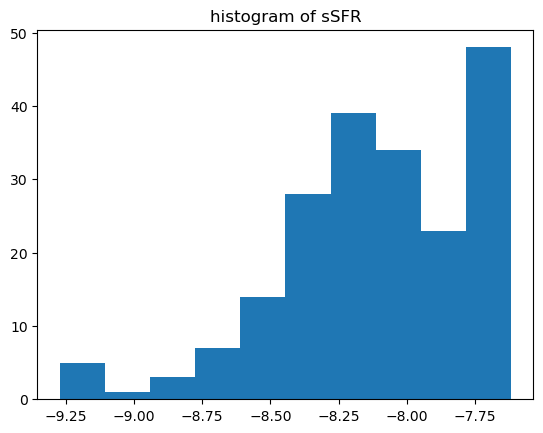

In [45]:
m_star = final_df['bayes.stellar.m_star'].values
sfr = final_df['bayes.sfh.sfr'].values
ssfr = np.log10(sfr/m_star)
print(ssfr)
plt.hist(ssfr)
plt.title('histogram of sSFR')

(array([150.,  22.,  13.,   4.,   6.,  10.,   0.,   0.,   2.,   1.]),
 array([1.00646026e-03, 2.88558835e-01, 5.76111210e-01, 8.63663585e-01,
        1.15121596e+00, 1.43876833e+00, 1.72632071e+00, 2.01387308e+00,
        2.30142546e+00, 2.58897783e+00, 2.87653021e+00]),
 <BarContainer object of 10 artists>)

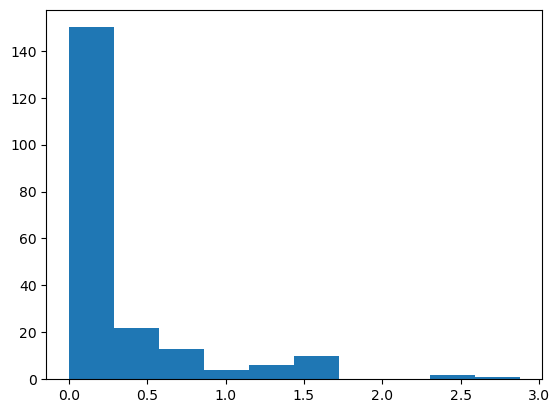

In [46]:
plt.hist(final_df['bayes.attenuation.E_BVs']*3.2)

## NOTES: Aug 20, 2024.<br>
### formatting stuff for our table:<br>
### M*: log10(mass) $\pm$ (0.434$\frac{uncertainty}{mass}$)<br>
### SFR: leave NO decimal
### z$_{phot}$: leave one significant figure (tenth decimal), same for error
### RA, Dec: follow form 00:00:00.00 (use code)
### log10(specific SFR) where Specific SFR = $\frac{SFR}{M*}$ and follows form "-8.2" or "-12"
### in cases where specific SFR < -12, just say "< -12".
### in cases where SFR is beyond one decimal point (0.03) then write 0. maybe note this down.

In [48]:
final_df[['ra', 'dec', 'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.universe.redshift']]

,ra,dec,bayes.stellar.m_star,bayes.sfh.sfr,bayes.universe.redshift
0,150.059622,2.379230,2.476156e+09,4.082569,4.857374
1,150.065793,2.380723,1.921869e+09,5.041217,4.937202
2,150.066598,2.380856,3.589874e+09,2.005455,4.934577
3,150.066115,2.383224,4.860648e+07,0.701450,2.310612
4,150.069042,2.384513,4.740173e+07,0.347077,1.660271
...,...,...,...,...,...
203,150.112749,2.330474,2.628109e+08,1.178090,4.119372
204,150.106560,2.333423,2.299701e+08,1.457550,4.258428
205,150.108001,2.333181,3.390000e+07,0.228684,2.540534
206,150.112878,2.331558,4.760431e+07,0.487810,3.015252


In [49]:
# this saves the RA and Dec into 00:00:00.00 format, which we'll then use for our LaTeX table.
# the code was copy-pasted from Arianna, of course.
save_coords = SkyCoord(final_df['ra'].values*u.deg, final_df['dec'].values*u.deg)
ras = []
decs = []
for i in zip(save_coords.ra.hms[0], save_coords.ra.hms[1],save_coords.ra.hms[2]):
    if (len(str(round(i[2],2))) >= 5):
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
    elif ((len(str(round(i[2],2))) == 4) & (round(i[2],2) < 10)):
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(5))
    else:
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
for i in zip(save_coords.dec.dms[0], save_coords.dec.dms[1],save_coords.dec.dms[2]):
    if (len(str(round(i[2],2))) >= 5):
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
    elif ((len(str(round(i[2],2))) == 4) & (round(i[2],2) < 10)):
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(5))
    else:
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))

In [50]:
# this saves the redshift values into one-decimal form, which we'll use for our LaTeX table.
photz_values = np.round(final_df['bayes.universe.redshift'].values, 1)
photz_errors = np.round(final_df['bayes.universe.redshift_err'].values, 1)
photz = []
for z_idx in range(np.size(photz_values)):
    photz.append(str(photz_values[z_idx]) + ' $' + chr(92) + 'pm$ ' + str(photz_errors[z_idx]))

In [51]:
# this saves the M* into log10(mass) +- (0.434*uncertainty/mass) form, which we'll use for our LaTeX table.
mass_values = np.round(np.log10(final_df['bayes.stellar.m_star'].values), 2)
mass_errors = np.round(0.434 * final_df['bayes.stellar.m_star_err'].values / final_df['bayes.stellar.m_star'].values, 2)
mass = []
for m_idx in range(np.size(mass_values)):
    mass.append(str(mass_values[m_idx]) + ' $' + chr(92) + 'pm$ ' + str(mass_errors[m_idx]))

/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_1007/3445690657.py:2: RuntimeWarning: divide by zero encountered in log10
  mass_values = np.round(np.log10(final_df['bayes.stellar.m_star'].values), 2)
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_1007/3445690657.py:3: RuntimeWarning: invalid value encountered in divide
  mass_errors = np.round(0.434 * final_df['bayes.stellar.m_star_err'].values / final_df['bayes.stellar.m_star'].values, 2)


In [52]:
# this saves the SFR values into decimal-less form, which we'll use for our LaTeX table.
sfr_values = np.round(final_df['bayes.sfh.sfr'].values)
sfr_errors = np.round(final_df['bayes.sfh.sfr_err'].values)
sfr = []
for sfr_idx in range(np.size(sfr_values)):
    sfr.append(str(sfr_values[sfr_idx]) + ' $' + chr(92) + 'pm$ ' + str(sfr_errors[sfr_idx]))

In [53]:
# this saves the SSFR values
ssfr_calc = np.log10(final_df['bayes.sfh.sfr'].values / final_df['bayes.stellar.m_star'].values)
ssfr = []
for ssfr_value in ssfr_calc:
    ssfr.append(str(np.round(ssfr_value, 2)))

/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_1007/1618494161.py:2: RuntimeWarning: invalid value encountered in divide
  ssfr_calc = np.log10(final_df['bayes.sfh.sfr'].values / final_df['bayes.stellar.m_star'].values)


In [54]:
latex_table = {'R.A.': ras, 'Decl.': decs, 'z$_{phot}$': photz, 
               'log$_{10}$(M$_*$/M$_\odot$)': mass, 'SFR/yr': sfr, 'log$_{10}$(sSFR/yr)': ssfr}
latex = pd.DataFrame(latex_table)

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_1007/1298745413.py:2: SyntaxWarning: invalid escape sequence '\o'
  'log$_{10}$(M$_*$/M$_\odot$)': mass, 'SFR/yr': sfr, 'log$_{10}$(sSFR/yr)': ssfr}


In [55]:
latex

,R.A.,Decl.,z$_{phot}$,log$_{10}$(M$_*$/M$_\odot$),SFR/yr,log$_{10}$(sSFR/yr)
0,10:00:14.31,$+$02:22:45.23,4.9 $\pm$ 0.2,9.39 $\pm$ 0.1,4.0 $\pm$ 7.0,-8.78
1,10:00:15.79,$+$02:22:50.6,4.9 $\pm$ 0.1,9.28 $\pm$ 0.06,5.0 $\pm$ 1.0,-8.58
2,10:00:15.98,$+$02:22:51.08,4.9 $\pm$ 0.2,9.56 $\pm$ 0.06,2.0 $\pm$ 2.0,-9.25
3,10:00:15.87,$+$02:22:59.61,2.3 $\pm$ 2.0,7.69 $\pm$ 0.5,1.0 $\pm$ 1.0,-7.84
4,10:00:16.57,$+$02:23:04.25,1.7 $\pm$ 1.7,7.68 $\pm$ 0.69,0.0 $\pm$ 1.0,-8.14
...,...,...,...,...,...,...
203,10:00:27.06,$+$02:19:49.71,4.1 $\pm$ 1.2,8.42 $\pm$ 0.24,1.0 $\pm$ 1.0,-8.35
204,10:00:25.57,$+$02:20:00.32,4.3 $\pm$ 1.0,8.36 $\pm$ 0.25,1.0 $\pm$ 1.0,-8.2
205,10:00:25.92,$+$02:19:59.45,2.5 $\pm$ 0.3,7.53 $\pm$ 0.15,0.0 $\pm$ 0.0,-8.17
206,10:00:27.09,$+$02:19:53.61,3.0 $\pm$ 0.7,7.68 $\pm$ 0.25,0.0 $\pm$ 0.0,-7.99


In [56]:
print(latex.to_latex(index=False))

\begin{tabular}{llllll}
\toprule
R.A. & Decl. & z$_{phot}$ & log$_{10}$(M$_*$/M$_\odot$) & SFR/yr & log$_{10}$(sSFR/yr) \\
\midrule
10:00:14.31 & $+$02:22:45.23 & 4.9 $\pm$ 0.2 & 9.39 $\pm$ 0.1 & 4.0 $\pm$ 7.0 & -8.78 \\
10:00:15.79 & $+$02:22:50.6 & 4.9 $\pm$ 0.1 & 9.28 $\pm$ 0.06 & 5.0 $\pm$ 1.0 & -8.58 \\
10:00:15.98 & $+$02:22:51.08 & 4.9 $\pm$ 0.2 & 9.56 $\pm$ 0.06 & 2.0 $\pm$ 2.0 & -9.25 \\
10:00:15.87 & $+$02:22:59.61 & 2.3 $\pm$ 2.0 & 7.69 $\pm$ 0.5 & 1.0 $\pm$ 1.0 & -7.84 \\
10:00:16.57 & $+$02:23:04.25 & 1.7 $\pm$ 1.7 & 7.68 $\pm$ 0.69 & 0.0 $\pm$ 1.0 & -8.14 \\
10:00:20.74 & $+$02:23:43.31 & 3.5 $\pm$ 0.0 & 10.1 $\pm$ 0.02 & 9.0 $\pm$ 1.0 & -9.15 \\
10:00:21.12 & $+$02:23:41.7 & 5.1 $\pm$ 0.2 & 9.64 $\pm$ 0.04 & 2.0 $\pm$ 1.0 & -9.27 \\
10:00:21.03 & $+$02:23:56.17 & 4.7 $\pm$ 0.8 & 8.79 $\pm$ 0.14 & 2.0 $\pm$ 1.0 & -8.44 \\
10:01:44.17 & $+$02:27:49.99 & 4.9 $\pm$ 0.5 & 9.1 $\pm$ 0.11 & 4.0 $\pm$ 2.0 & -8.53 \\
10:01:45.84 & $+$02:27:53.86 & 5.7 $\pm$ 2.4 & 8.82 $\pm$ 0.25 